In [2]:
import numpy as np
import numba
import seaborn as sns
import pandas
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
plotsdir = "/Users/billiemeadowcroft/Dropbox/PHD_data/Dumbbells/Theory/Plots/"
#datadir = '/Users/billiemeadowcroft/Documents/PHD/Dumbbells/Data/'

In [3]:
def tsph(Rsph,Rcyl,W,sigma,kappa,eta):
    v_sig = sigma/(Rsph*eta)
    v_up = W/(Rsph*eta) - (2*kappa)/(Rsph*Rsph*Rsph*eta)
    SqrtFact = np.sqrt(1-(2*v_sig/v_up))
    TanFact = (1/2)*(np.pi/2 + np.arccos(Rcyl/Rsph))
    t = (2/(v_up*SqrtFact))*np.arctan(SqrtFact*np.tan(TanFact))
    
    return t

def tcyl(Rcyl,l,W,sigma,kappa,eta):
    v_up = W/eta - sigma/eta - kappa/(2*eta*Rcyl*Rcyl)
    t = l/v_up
    
    return t


In [4]:
def FindPdiff(rat,init):
    Number = 45130
    No_OUT = Number * init
    No_IN = rat*No_OUT/41.8 #41.8 is how many OUT:IN we have when rat = 1
    Vin_cell  = 6326 #in sigma
    Vbox_nocell = 265621 #in sigma
    pIN = No_IN/Vin_cell #in number/volume(sigma)
    pOUT = No_OUT/Vbox_nocell 
    Difference = pIN-pOUT
    return Difference #/sigma^3 for real units?

#real units when sigma = 10nm, Temp (=1 in lj) = epsilon = 4.34kT?, 

def RealUnits(press):
    T = 4.34 #related to epsilon
    sigma = 10**-6 #our simulation length unit matched to their dumbbell in [m]
    sigmaCube = sigma*sigma*sigma #apparently sigma = 10^-7 (if d = 7.5, their d = 1 micron)
    Pressure = T*press/(72.46) #N/m^2 (72.46 = sigma^3/kB)
    #PressureV2 = T*press/sigmaCube 
    r = 17*sigma
    Tension1 = Pressure*r/4
    #Tension1 = Pressure*1.7*(10**-6)/2 #N/m
    #Tension1V2 = PressureV2*1.7*(10**-6)/2 #N/m (1.7*10^-6 = R in m)
    Tension2 = Tension1*10**9 #nN/(m)
    #Tension2V2 = Tension1V2*10**-9 #N/(nm)
    
    return Tension2, 5 #nN/m, us

PARAMETERS

In [5]:
Rsph = 0.0000005 #meter
Rcyl = Rsph/20 #meter
L = Rsph/10 #meter
kappa = 8.0868E-20 #Joules
sigma0 = 1E-9 #N/m
eta0 = 0.4 #PaS  eta_water = 0.001 (=100*eta_water)
W0 = 0.00000065 #J/m^2 (=1*microJ/m^2)

ExpTime = [9.41667,15.21667,16.23333,24.5,100,170]
ExpTen=[5,6,6,9,15,51]
ExpTenUnits = [5E-9,6E-9,6E-9,9E-9,15E-9,51E-9]
xerr= [14,10,14,20,12,5]
yerr = [2,2,2,2,2,2]

NT = 100
NW = 8
NE = 10

finding sum of standard \chi^2 = sum((yi-ci/(stdi))^2)

/var/folders/wt/4tgp65891vd4l6wskkxdnvk40000gn/T/ipykernel_2926/1428981032.py:4: RuntimeWarning: invalid value encountered in sqrt
  SqrtFact = np.sqrt(1-(2*v_sig/v_up))


Text(0.5, 15.0, 'Effective viscosity $\\eta_{\\mathrm{eff}}$ [PaS]')

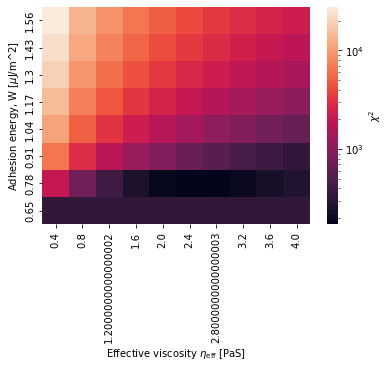

In [6]:
chiSquared = np.zeros((NW,NE))
Ws = []
etas = []
for j in range(NW):
    W = W0+W0*j/5
    Ws.append(W)
    
    for k in range(NE):
        chiSq= 0
        eta = eta0+eta0*k
        if j==0:
            etas.append(eta)
        for ii in range(len(ExpTime)):
            UptakeTime = tcyl(Rcyl,L,W,ExpTenUnits[ii],kappa,eta)+ 2*tsph(Rsph,Rcyl,W,ExpTenUnits[ii],kappa,eta)
            if UptakeTime==UptakeTime:
                chiSq+=((ExpTime[ii]-UptakeTime)**2/(UptakeTime))
            else: 
                chiSq+=((ExpTime[ii])**2/(ExpTime[ii]))
            #if chiSq !=chiSq:
            #    print(eta,W,ii)
        chiSquared[j,k] = chiSq
        
Ws_ = np.round(np.multiply(Ws,1E6),2) #in micro J/m^2
fig3,ax3 = plt.subplots()
sns.heatmap(chiSquared,xticklabels=etas,yticklabels=Ws_,ax=ax3,norm=LogNorm(),cbar_kws={'label': r'$\chi^{2}$'})
ax3.invert_yaxis()
#n = 2  # Keeps every 2nd label\n",
#[l.set_visible(False) for (i,l) in enumerate(ax3.xaxis.get_ticklabels()) if i % n != 0]
#[l.set_visible(False) for (i,l) in enumerate(ax3.yaxis.get_ticklabels()) if i % n != 0]
ax3.set_ylabel(r"Adhesion energy, W [$\mu$J/m^2]")
ax3.set_xlabel(r"Effective viscosity $\eta_{\mathrm{eff}}$ [PaS]")

In [7]:
Tens = []
Ws = []
etas = []
NT = 8
NW = 100
NE = 1
W0 = 0.00000065
#k=0
TimeTens = np.zeros((NT,NW,NE))
print(np.shape(TimeTens))
Ws = []
def criticalW(sigma, eta, kappa,R):
    wcrit = 2*kappa/(R*R)+sigma
    #print(type(R),type(kappa))
    wcrit2 = 2*kappa/(R*R)
    
    return wcrit, wcrit2

wc_ = np.zeros((NT))
wc2_ = np.zeros((NT))
Ws = []
for i in range(NT):
    sigma = -sigma0/10 + sigma0*(i*2/.3+1)
    Tens.append(sigma)
    wc_[i] = criticalW(sigma, eta0, kappa,Rsph)[0]
    wc2_[i] = criticalW(sigma, eta0, kappa,Rsph)[1]
    for j in range(NW):
        W = W0+W0*j/400
        if i ==0 :
            Ws.append(W)
        for k in range(NE):
            eta = eta0+eta0*k
            if i ==0 and j ==0:
                etas.append(eta)
        
            UptakeTime = tcyl(Rcyl,L,W,sigma,kappa,eta)+ 2*tsph(Rsph,Rcyl,W,sigma,kappa,eta)
            if UptakeTime > 0:
                TimeTens[i,j,k] = UptakeTime
            else:
                TimeTens[i,j,k] = None
Ws_ = np.round(np.multiply(Ws,1E6),4) #in micro J/m^2
Tens_ = np.round(np.multiply(Tens,1E9),1) #in nN/m
print(np.shape(TimeTens))
print(TimeTens[2,5,0])

(8, 100, 1)
(8, 100, 1)
nan


/var/folders/wt/4tgp65891vd4l6wskkxdnvk40000gn/T/ipykernel_2926/1428981032.py:4: RuntimeWarning: invalid value encountered in sqrt
  SqrtFact = np.sqrt(1-(2*v_sig/v_up))


In [8]:
TensF = []
WsF = []
etas = []
NT = 8
NW = 100
NE = 1
#k=0
TimeTensF = np.zeros((NT,NW,NE))
print(np.shape(TimeTens))

def criticalW(sigma, eta, kappa,R):
    wcrit = 2*kappa/(R*R)+sigma
    #print(type(R),type(kappa))
    wcrit2 = 2*kappa/(R*R)
    
    return wcrit, wcrit2

wc_ = np.zeros((NT))
wc2_ = np.zeros((NT))
W0 = 0.000001 
for i in range(NT):
    sigma = -sigma0/10 + sigma0*(i*2/.3+1)
    TensF.append(sigma)
    wc_[i] = criticalW(sigma, eta0, kappa,Rsph)[0]
    wc2_[i] = criticalW(sigma, eta0, kappa,Rsph)[1]
    for j in range(NW):
        W = W0+W0*j/400
        if i ==0 :
            WsF.append(W)
        for k in range(NE):
            eta = eta0+eta0*k
            if i ==0 and j ==0:
                etas.append(eta)
        
            UptakeTime = tcyl(Rcyl,L,W,sigma,kappa,eta)+ 2*tsph(Rsph,Rcyl,W,sigma,kappa,eta)
            if UptakeTime > 0:
                TimeTensF[i,j,k] = UptakeTime
            else:
                TimeTensF[i,j,k] = None
WsF_ = np.round(np.multiply(WsF,1E6),4) #in micro J/m^2
TensF_ = np.round(np.multiply(TensF,1E9),1) #in nN/m
print(np.shape(TimeTens))
print(TimeTens[2,5,0])

(8, 100, 1)
(8, 100, 1)
nan


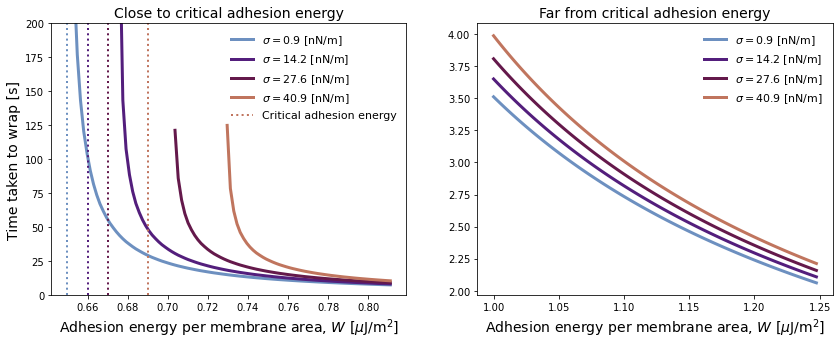

In [11]:
clrs = ["teal","mediumseagreen", "tab:green", "teal", "tab:pink","darkviolet"]
clrs2 = ["lightcoral", "firebrick", "maroon", "black"]
clrs = ["steelblue", "firebrick", "maroon", "black"]
cmap = plt.cm.get_cmap('twilight')

etas_ = np.round(etas,2)
fig,ax = plt.subplots(1,2,figsize = (14,5))
ax[0].set_ylabel("Time taken to wrap [s]", fontsize = 14)
ax[0].set_ylim([0,200])
wc = np.round(np.multiply(wc_,1E6),2)
wc2 = np.round(np.multiply(wc2_,1E6),2)
for ii in range(4):
    i = ii*2
    ax[0].plot(Ws_, TimeTens[i,:,0],color = cmap((ii+1)/5),linestyle = '-', marker = '', linewidth = 3, label = r'$\sigma = $'+str(Tens_[i])+' [nN/m]')
    if ii == 3:
        ax[0].plot([wc[i],wc[i]], [0,200],color = cmap((ii+1)/5),linestyle = ':', marker = '', linewidth = 2, label = r'Critical adhesion energy')
    else:
        ax[0].plot([wc[i],wc[i]], [0,200],color = cmap((ii+1)/5),linestyle = ':', marker = '', linewidth = 2)
ax[0].set_title('Close to critical adhesion energy', fontsize = 14)
ax[0].legend(frameon=False,fontsize = 11)
ax[0].set_xlabel(r"Adhesion energy per membrane area, $W ~[\mu$J/$\mathrm{m}^{2}]$", fontsize = 14)


for ii in range(4):
    i = ii*2
    ax[1].plot(WsF_, TimeTensF[i,:,0],color = cmap((ii+1)/5),linestyle = '-', marker = '', linewidth = 3, label = r'$\sigma = $'+str(TensF_[i])+' [nN/m]')
ax[1].set_title('Far from critical adhesion energy', fontsize = 14)
ax[1].legend(frameon=False,fontsize = 11)
ax[1].set_xlabel(r"Adhesion energy per membrane area, $W ~[\mu$J/$\mathrm{m}^{2}]$", fontsize = 14)


fname = "TimeVsW_eta0.4.pdf"
fig.savefig(plotsdir+fname)